In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [3]:
data = pd.read_csv('./data/teams.csv')

## Data Processing

We started by sorting the teams dataframe by franchise and year, and shifting the playoff stat to the previous year, so each row has a 'playoffNextYear' column.

In [4]:
# Create label
data = data.sort_values(['franchID', 'year'])
data['playoffNextYear'] = data['playoff'].shift(-1)
data.loc[data['franchID'] != data['franchID'].shift(-1), 'playoffNextYear'] = None
data.dropna(subset='playoffNextYear', inplace=True)

As we will initially be teaching from years 1-5 and predict the playoff teams from year 6, we are going to limit the dataframe to those years. Therefore, we now need to accumulate the data from the first 5 years, which means we should do features like:
    
- Percentage of times that a team reached a certain stage
- Win rates
- Averages


In [8]:
df5 = data[data['year'] <= 5]

# Calculate percentages of achieving these rounds
df_playoff = df5[['franchID', 'playoff', 'firstRound', 'semis', 'finals']]

grouped_df_playoff = df_playoff.groupby('franchID')

# Calculate percentages
playoff_percentage = grouped_df_playoff.apply(lambda x: (x['playoff'] == 'Y').sum() / len(x) * 100)
firstRound_percentage = grouped_df_playoff.apply(lambda x: (x['firstRound'] == 'Y').sum() / len(x) * 100)
semis_percentage = grouped_df_playoff.apply(lambda x: (x['semis'] == 'Y').sum() / len(x) * 100)
finals_percentage = grouped_df_playoff.apply(lambda x: (x['finals'] == 'Y').sum() / len(x) * 100)

#Convert to DF
playoff_percentage_df = playoff_percentage.reset_index()
playoff_percentage_df.columns = ['franchID', 'playoff%']

firstRound_percentage_df = firstRound_percentage.reset_index()
firstRound_percentage_df.columns = ['franchID', 'firstRound%']

semis_percentage_df = semis_percentage.reset_index()
semis_percentage_df.columns = ['franchID', 'semis%']

finals_percentage_df = finals_percentage.reset_index()
finals_percentage_df.columns = ['franchID', 'finals%']

# Merge percentages to main dataframe
df5 = df5.merge(playoff_percentage_df, on='franchID', how='left')
df5 = df5.merge(firstRound_percentage_df, on='franchID', how='left')
df5 = df5.merge(semis_percentage_df, on='franchID', how='left')
df5 = df5.merge(finals_percentage_df, on='franchID', how='left')

df5 = df5.drop(columns=['year', 'playoff', 'firstRound', 'semis', 'finals'])

# Group features
df5 = df5.groupby('franchID').agg({
    "lgID": "first",
    "tmID": "first",
    "franchID": "first",
    "confID": "first",
    "divID" : "first",
    "rank": "mean",
    "playoff%": "first",
    "firstRound%": "first",
    "semis%": "first",
    "finals%": "first",
    "o_fgm": "mean",
    "o_fga": "mean",
    "o_ftm": "mean",
    "o_fta": "mean",
    "o_3pm": "mean",
    "o_3pa": "mean",
    "o_oreb": "mean",
    "o_dreb": "mean",
    "o_reb": "mean",
    "o_asts": "mean",
    "o_pf": "mean",
    "o_stl": "mean",
    "o_to": "mean",
    "o_blk": "mean",
    "o_pts": "mean",
    "d_fgm": "mean",
    "d_fga": "mean",
    "d_ftm": "mean",
    "d_fta": "mean",
    "d_3pm": "mean",
    "d_3pa": "mean",
    "d_oreb": "mean",
    "d_dreb": "mean",
    "d_reb": "mean",
    "d_asts": "mean",
    "d_pf": "mean",
    "d_stl": "mean",
    "d_to": "mean",
    "d_blk": "mean",
    "d_pts": "mean",
    "tmORB": "mean",
    "tmDRB": "mean",
    "tmTRB": "mean",
    "opptmORB": "mean",
    "opptmDRB": "mean",
    "opptmTRB": "mean",
    "won": "sum",
    "lost": "sum",
    "GP": "sum",
    "homeW": "sum",
    "homeL": "sum",
    "awayW": "sum",
    "awayL": "sum",
    "confW": "sum",
    "confL": "sum",
    "min": "sum",
    "attend": "mean",
    "arena": "first",
})

df5.head()

,lgID,tmID,franchID,confID,divID,rank,playoff%,firstRound%,semis%,finals%,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
franchID,,,,,,,,,,,,,,,,,,,,,
CHA,WNBA,CHA,CHA,EA,NaN,4.200000,60.000000,0.0,0.0,0.0,...,164,50,32,28,54,52,55,33175,107920.4,Charlotte Coliseum
CLE,WNBA,CLE,CLE,EA,NaN,3.333333,66.666667,0.0,0.0,0.0,...,96,31,17,18,30,35,28,19475,144663.0,Quicken Loans Arena
CON,WNBA,ORL,CON,EA,NaN,3.400000,60.000000,0.0,0.0,0.0,...,164,51,31,30,52,60,47,33250,113394.2,Amway Arena
DET,WNBA,DET,DET,EA,NaN,4.800000,40.000000,0.0,0.0,0.0,...,164,42,40,33,49,52,55,33175,121063.0,The Palace of Auburn Hills
HOU,WNBA,HOU,HOU,WE,NaN,3.200000,80.000000,0.0,0.0,0.0,...,164,62,20,41,41,67,42,33025,170699.6,Compaq Center


In [15]:
features = ['rank', 'o_fgm', 'o_ftm', 'o_3pm', 'o_reb', 'o_asts', 'o_pts']
label = 'playoffNextYear'

In [16]:
train_data = df5
test_data = data[data['year'].isin([6, 7])].copy()

In [17]:
x_train, y_train = train_data[features], train_data[label]
x_test, y_test = test_data[features], test_data[label]

In [18]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
test_data['predict'] = model.predict(x_test)
print(accuracy_score(y_test, test_data['predict']))

0.6153846153846154


In [20]:
plt.rcParams['figure.figsize'] = (16, 9)

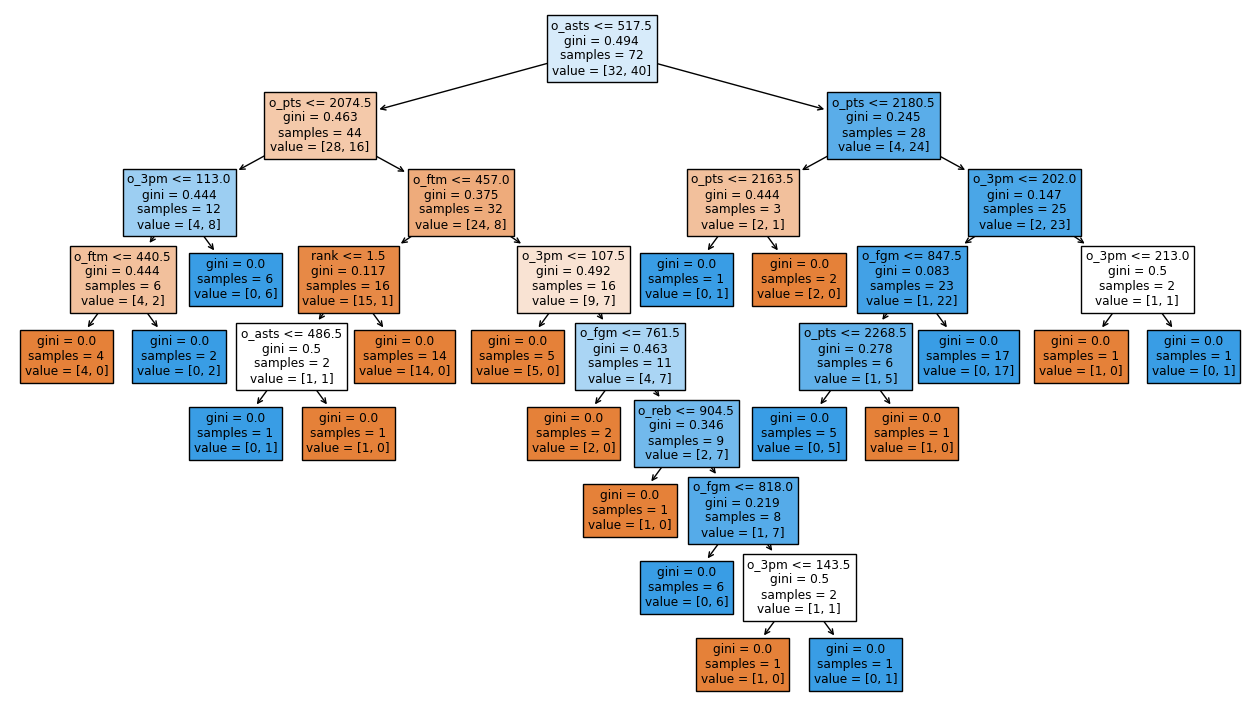

In [19]:
plot_tree(model, feature_names=features, filled=True);